## Chapter 5: The Simple Recurrent Neural Network

RNNs contain hidden states which are distributed across time.
This allows them to efficiently **store a lot of information about
the past**. As with a regular deep neural network, the nonlinear
dynamics allows them to update their hidden state in
complicated ways.

In this chapter, we use
the Keras library to build a simple recurrent neural network to
forecast COE price.


**Keras** is a deep learning library for Theano and TensorFlow. Keras is a high-level neural networks library, capable of
running on top of either TensorFlow or Theano.

**Theano** allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently.

**TensorFlow** is a library for numerical computation using graphs.

Until now we used **static neural network** which they don't have no feedback elements. In a **dynamic neural network**, the output depends on the current input to the network, and the previous inputs, outputs, and/or hidden states of the network. Recurrent neural networks are an example of a dynamic network.

The idea is that the recurrent connections allow a **memory of previous inputs to persist in the network’s internal
state**, and thereby influence the network’s output. The value held in the **delay unit** is fed back to the hidden units as additional inputs.

The **delay unit** enables the network to have **short-term memory**.
This is because it **stores the hidden layer activation values (or
output) of the previous time step**. It **releases these values** back
into the network at **the subsequent time step**. In other words,
the **RNN has a “memory”** which captures information about
what has been calculated by the hidden units at an earlier
time step.

**NOTE:** An RNN basically takes the output of each hidden
or output layer, and feeds it back to itself (via the
delay node) as an additional input. The delay loop
allows information to be passed from one time step
of the network to the next.

In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import preprocessing

In [33]:
# Load data
loc = "COE.csv"
temp = pd.read_csv(loc)

# Select Data
data = temp.drop(temp.columns[[0,1]], axis = 1)
y = data['COE$']
x = data.drop(data.columns[[0,4]], axis = 1)

# Normalize Data applying Log transformation
x = x.apply(np.log)
# Add column Open? to x dataframe
x = pd.concat([x,data['Open?']], axis =1)

# The attributes are scaled to lie in the 0 to 1 range
# Notice that x is reshaped by number of attributes into a numpy ndarray. 
# Hence the value “4” refers to the number of attributes. 
scaler_x = preprocessing.MinMaxScaler(feature_range=(0, 1))
x = np.array(x).reshape((len(x),4))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler(feature_range=(0, 1))
y = np.array(y).reshape((len(y),1))
y = np.log(y)
y = scaler_y.fit_transform(y)

The train set contains around 95% of the
observations, with the remaining allocated to the test set

In [34]:
end = len(x) -1 
learn_end = int(end * 0.954)

x_train = x[0:learn_end-1,]
x_test = x[learn_end:end-1,]

y_train = y[1:learn_end]
y_test = y[learn_end + 1:end]

# The reshape the training and test set attributes into a suitable format for passing to the
# Keras library. The shape is of the form (number of samples, number of features,time_steps).
x_train = x_train.reshape(x_train.shape+(1,))
x_test = x_test.reshape(x_test.shape+(1,))

print("Shape of x_train is ", x_train.shape)
print("Shape of x_test is ", x_test.shape)

Shape of x_train is  (250, 4, 1)
Shape of x_test is  (12, 4, 1)


**Unfolding** simple unrolls the recurrent loop over time to
reveal a feedforward neural network. The unfolded RNN is
**essentially a deep neural network where each layer corresponds
to a time step in the original RNN.**

The resultant feed-forward network can be trained using the
backpropagation algorithm. Computing the derivatives of error
with respect to weights is reduced to **computing the derivatives
in each layer of a feed forward network.** Once the network is
trained, the feed-forward network “folds” itself obtaining the
original RNN.

In [35]:
# The first line imports the Keras Sequential model. 
# It allows the linear stacking of layers.
from keras.models import Sequential

# This line imports the optimizatoin Stochastic Gradient descent
from keras.optimizers import SGD

# This line imports the activation functions and a
# dense layer, this is a regular fully connected neural network
# layer. We use it for the output layer.
from keras.layers.core import Dense, Activation

# This line imports a fully-connected RNN where the
# output is to be fed back to input
from keras.layers.recurrent import SimpleRNN

In [36]:
seed = 2016
np.random.seed(seed)

# The model is sotred in fit1 variable
fit1 = Sequential()
# The model consists of a RNN with 8 delay nodes with tanh activation functions.
# The input_shape argument takes the number of features (in this case 4) 
# and the number of time steps (in this case 1) 
fit1.add(SimpleRNN(output_dim = 8, activation = 'tanh', input_shape = (4,1)))
#The output layer is a fully connected layer with 1 output
# (our COE forecast) via a linear activation function.
fit1.add(Dense(output_dim=1, activation='linear'))

c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(activation="tanh", input_shape=(4, 1), units=8)`
  if __name__ == '__main__':
c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  if sys.path[0] == '':


### Mommentum Term

This help the network out of local minima. It can take a value between 0 and 1. It adds this fraction of the previous weight update to the current one. A high value
for the momentum parameter, say 0.9, can reduce training time
and help the network avoid getting trapped in local minima.

However, setting the momentum parameter too high can
increase the risk of overshooting the global minimum. This is
further increased if you combine a high learning rate with a lot
of momentum. However, if you set the momentum coefficient
too low the model will lack sufficient energy to jump over local
minima.

**One rule of thumb**
is to reduce the learning rate when using a lot of momentum.
Using this idea we select a low learning rate of 0.0001 combined
with a relatively high momentum value of 0.95

**Notice** we set nestrov = True to use Nesterov’s accelerated
gradient descent. This is a first-order optimization method
designed to improve stability and speed up convergence of gradient
descent. 

During regular gradient descent the gradient is
used to update the weights. Use of the nestrov
algorithm adds a momentum term to the gradient
updates to speed things up a little.

In [37]:
sgd = SGD(lr = 0.001, momentum = 0.95, nesterov=True)
fit1.compile(loss="mean_squared_error", optimizer = sgd)

### Mini Batching
Mini batching is one common approach **to speeding up neural
network computation.** It involves computing the gradient
on several training examples (batches) together, rather than for
each individual example as happens in the original stochastic
gradient descent algorithm.

**A batch contains several training examples in one forward/
backward pass.** To get a sense of the computational efficiency
of min-batching, suppose you had a batch size of 500, with 1000 training examples. 
It will take only 2 iterations to complete 1 epoch.

N_interations_per_epoch =  N_train_examples / batch_size 

**Note:** The larger the batch size, the more memory you
will need to run the model.

In [38]:
# Fitting the model
fit1.fit(x_train,y_train, batch_size=10, nb_epoch=700)

# Evaluate the model
score_train =  fit1.evaluate(x_train, y_train, batch_size=10)
score_test =  fit1.evaluate(x_test, y_test, batch_size=10)

# print the MSE
print("In train MSE = ", round(score_train,6))
print("In test MSE = ", round(score_test,6))


c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/700
250/250 [==============================] - 0s 1ms/step - loss: 0.1127
Epoch 2/700
250/250 [==============================] - 0s 180us/step - loss: 0.0382
Epoch 3/700
250/250 [==============================] - 0s 160us/step - loss: 0.0246
Epoch 4/700
250/250 [==============================] - 0s 156us/step - loss: 0.0211
Epoch 5/700
250/250 [==============================] - ETA: 0s - loss: 0.007 - 0s 170us/step - loss: 0.0175
Epoch 6/700
250/250 [==============================] - 0s 140us/step - loss: 0.0149
Epoch 7/700
250/250 [==============================] - 0s 144us/step - loss: 0.0133
Epoch 8/700
250/250 [==============================] - 0s 148us/step - loss: 0.0120
Epoch 9/700
250/250 [==============================] - 0s 168us/step - loss: 0.0110
Epoch 10/700
250/250 [==============================] - 0s 156us/step - loss: 0.0102
Epoch 11/700
250/250 [==============================] - 0s 170us/step - loss: 0.0095
Epoch 12/700
250/250 [==============================

250/250 [==============================] - 0s 138us/step - loss: 0.0030
Epoch 193/700
250/250 [==============================] - 0s 124us/step - loss: 0.0030
Epoch 194/700
250/250 [==============================] - 0s 116us/step - loss: 0.0030
Epoch 195/700
250/250 [==============================] - 0s 116us/step - loss: 0.0030
Epoch 196/700
250/250 [==============================] - 0s 132us/step - loss: 0.0030
Epoch 197/700
250/250 [==============================] - 0s 166us/step - loss: 0.0030
Epoch 198/700
250/250 [==============================] - 0s 140us/step - loss: 0.0031
Epoch 199/700
250/250 [==============================] - 0s 138us/step - loss: 0.0030
Epoch 200/700
250/250 [==============================] - 0s 128us/step - loss: 0.0030
Epoch 201/700
250/250 [==============================] - 0s 136us/step - loss: 0.0030
Epoch 202/700
250/250 [==============================] - 0s 142us/step - loss: 0.0030
Epoch 203/700
250/250 [==============================] - 0s 120us/st

250/250 [==============================] - 0s 128us/step - loss: 0.0028
Epoch 288/700
250/250 [==============================] - 0s 124us/step - loss: 0.0028
Epoch 289/700
250/250 [==============================] - 0s 128us/step - loss: 0.0028
Epoch 290/700
250/250 [==============================] - 0s 112us/step - loss: 0.0029
Epoch 291/700
250/250 [==============================] - 0s 112us/step - loss: 0.0028
Epoch 292/700
250/250 [==============================] - 0s 128us/step - loss: 0.0028
Epoch 293/700
250/250 [==============================] - 0s 142us/step - loss: 0.0028
Epoch 294/700
250/250 [==============================] - 0s 124us/step - loss: 0.0028
Epoch 295/700
250/250 [==============================] - 0s 116us/step - loss: 0.0028
Epoch 296/700
250/250 [==============================] - 0s 116us/step - loss: 0.0028
Epoch 297/700
250/250 [==============================] - 0s 140us/step - loss: 0.0028
Epoch 298/700
250/250 [==============================] - 0s 132us/st

250/250 [==============================] - 0s 124us/step - loss: 0.0027
Epoch 478/700
250/250 [==============================] - 0s 132us/step - loss: 0.0026
Epoch 479/700
250/250 [==============================] - 0s 124us/step - loss: 0.0026
Epoch 480/700
250/250 [==============================] - 0s 128us/step - loss: 0.0026
Epoch 481/700
250/250 [==============================] - 0s 132us/step - loss: 0.0025
Epoch 482/700
250/250 [==============================] - 0s 128us/step - loss: 0.0025
Epoch 483/700
250/250 [==============================] - 0s 120us/step - loss: 0.0026
Epoch 484/700
250/250 [==============================] - 0s 128us/step - loss: 0.0026
Epoch 485/700
250/250 [==============================] - 0s 124us/step - loss: 0.0025
Epoch 486/700
250/250 [==============================] - 0s 124us/step - loss: 0.0025
Epoch 487/700
250/250 [==============================] - 0s 124us/step - loss: 0.0026
Epoch 488/700
250/250 [==============================] - 0s 124us/st

250/250 [==============================] - 0s 144us/step - loss: 0.0024
Epoch 668/700
250/250 [==============================] - 0s 128us/step - loss: 0.0024
Epoch 669/700
250/250 [==============================] - 0s 128us/step - loss: 0.0024
Epoch 670/700
250/250 [==============================] - 0s 132us/step - loss: 0.0024
Epoch 671/700
250/250 [==============================] - 0s 144us/step - loss: 0.0024
Epoch 672/700
250/250 [==============================] - 0s 168us/step - loss: 0.0024
Epoch 673/700
250/250 [==============================] - 0s 140us/step - loss: 0.0024
Epoch 674/700
250/250 [==============================] - 0s 160us/step - loss: 0.0025
Epoch 675/700
250/250 [==============================] - 0s 184us/step - loss: 0.0025
Epoch 676/700
250/250 [==============================] - 0s 168us/step - loss: 0.0025
Epoch 677/700
250/250 [==============================] - 0s 168us/step - loss: 0.0024
Epoch 678/700
250/250 [==============================] - 0s 156us/st

### Convert the predictions back to their original scale

In [39]:
pred1 = fit1.predict(x_test)
pred1 = scaler_y.inverse_transform(np.array(pred1).reshape((len(pred1), 1)))
pred1 = np.exp(pred1)
print(np.rint(pred1))

[[15168.]
 [14266.]
 [14304.]
 [14480.]
 [15839.]
 [16417.]
 [17322.]
 [15778.]
 [15104.]
 [14763.]
 [15767.]
 [15982.]]


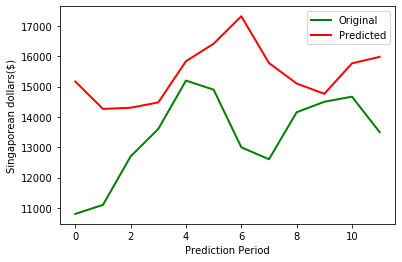

In [40]:
x_values = np.arange(12)

plt.plot(x_values,data.iloc[(264-12):264, 0], 'g-', linewidth=2, markersize=12)
plt.plot(x_values, pred1, 'r-', linewidth=2, markersize=12)

plt.xlabel('Prediction Period')
plt.ylabel('Singaporean dollars($)')
plt.legend(('Original', 'Predicted'),loc='upper right')

For an interesting application to **weather forecasting** see

"Using lagged and forecast climate indices with artificial intelligence to predict
monthly rainfall in the Brisbane Catchment, Queensland,
Australia." 

International Journal of Sustainable Development and Planning 10.1 (2015): 29-41.